Genera il training set campionando delle sinusoidi
Crea il discriminatore
Addestra il discriminatore
-------+-------------
 epoca | accuratezza 
-------+-------------
    0  |   0.484375
    1  |   0.46875
    2  |   0.5
    3  |   0.5546875
    4  |   0.546875
    5  |   0.5703125
    6  |   0.6484375
    7  |   0.6640625
    8  |   0.59375
    9  |   0.578125
   10  |   0.734375
   11  |   0.65625
   12  |   0.6484375
   13  |   0.6640625
   14  |   0.6640625
   15  |   0.7109375
   16  |   0.703125
   17  |   0.7265625
   18  |   0.6640625
   19  |   0.8046875
   20  |   0.78125
   21  |   0.7421875
   22  |   0.734375
   23  |   0.78125
   24  |   0.7421875
   25  |   0.8671875
   26  |   0.84375
   27  |   0.8046875
   28  |   0.828125
   29  |   0.8828125
   30  |   0.8203125
   31  |   0.8359375
Crea il generatore
Crea la GAN
Addestra la GAN
-------+------------------------+------------------------
 epoca | accuratezza discrimin. | accuratezza generatore 
-------+---------------

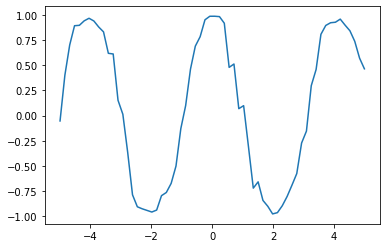

In [23]:
"""
    Generatore di curve sinusoidali

    (una curva è descritta da un insieme di punti (x,y) del piano)
"""

from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU

import numpy as np
from numpy.random import randint, uniform

import matplotlib.pyplot as plt

TRAIN_LEN = 64
TRAIN_SIZE = 8192
BATCH = 128
X_MIN, X_MAX = -5.0, 5.0
Y_MIN, Y_MAX = -1.0, 1.0

X_COORDS = np.linspace(X_MIN , X_MAX, TRAIN_LEN)

print("Genera il training set campionando delle sinusoidi")

X_TRAIN = np.zeros((TRAIN_SIZE, TRAIN_LEN))
for i in range(0, TRAIN_SIZE):
    scale = uniform(0.5, 2.0)
    phase = uniform(np.math.pi)
    X_TRAIN[i] = np.array([np.sin(scale*x + phase) for x in X_COORDS])

print("Crea il discriminatore")

DIS_DROPOUT = 0.4
discriminator = Sequential()
discriminator.add(Dense(TRAIN_LEN, activation = "relu"))
discriminator.add(Dropout(DIS_DROPOUT))
discriminator.add(Dense(SAMPLE_LEN, activation = "relu"))
discriminator.add(Dropout(DIS_DROPOUT))
discriminator.add(Dense(1, activation = "sigmoid"))
discriminator.compile(optimizer = "adam",
                      loss = "binary_crossentropy",
                      metrics = ["accuracy"])

print("Addestra il discriminatore")

BATCH_SIZE = 128
EPOCHS = 32

ONES = np.ones((BATCH_SIZE//2))   # vettore di label 1
ZEROS = np.zeros((BATCH_SIZE//2)) # vettore di label 0
ONEZEROS = (ONES, ZEROS)
NOISE = uniform(Y_MIN, Y_MAX, size = (TRAIN_SIZE, TRAIN_LEN))

print("-------+-------------")
print(" epoca | accuratezza ")
print("-------+-------------")

for i in range(EPOCHS):
  # Sceglie BATCH_SIZE//2 indici e li torna in n
  n = randint(0, TRAIN_SIZE, size = BATCH_SIZE//2)
  # Ora prepara un batch di training record, metà
  # training (label 1) metà a caso (label 0)
  x = np.concatenate((X_TRAIN[n], NOISE[n]))
  y = np.concatenate(ONEZEROS)
  dummy, acc = discriminator.train_on_batch(x, y)
  print(f"  {i:3}  |   {acc}")

print("Crea il generatore")

generator = Sequential()
generator.add(Dense(TRAIN_LEN, activation = "relu"))
generator.add(Dense(256, activation = "relu"))
generator.add(Dense(TRAIN_LEN, activation = "tanh"))
generator.compile(optimizer = "adam", loss = "mse", metrics = ["accuracy"])

print("Crea la GAN")

gan = Sequential()
gan.add(generator)
discriminator.trainable = False
gan.add(discriminator)
gan.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

print("Addestra la GAN")

EPOCHS = 64

print("-------+------------------------+------------------------")
print(" epoca | accuratezza discrimin. | accuratezza generatore ")
print("-------+------------------------+------------------------")

for e in range(EPOCHS):
    for k in range(TRAIN_SIZE//BATCH):
        n = randint(0, TRAIN_SIZE, size = BATCH//2)

        x = np.concatenate((X_TRAIN[n], generator.predict(NOISE[n])))
        y = np.concatenate(ONEZEROS)
        discriminator.trainable = True
        d_loss, d_acc = discriminator.train_on_batch(x, y)
        discriminator.trainable = False

        g_loss, g_acc = gan.train_on_batch(NOISE[n], ONES)
    
    print(f"  {e:03n}  |        {d_acc:.5f}         |       {g_acc:.5f}")

x = uniform(Y_MIN, Y_MAX, size = (1, TRAIN_LEN))
y = generator.predict(x)[0]

plt.plot(X_COORDS, y)
plt.show()
